# STOCK PREDICTION

### By - Varnica Sharma

#### Using Netflix Stock Dataset and predicting the price using LSTM

## Importing required libraries

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import math
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import LSTM
from warnings import filterwarnings
filterwarnings("ignore")

In [2]:
nflx = pd.read_csv("data/NFLX.csv")

## Gathering some info about data

In [3]:
nflx.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2002-05-23,1.156429,1.242857,1.145714,1.196429,1.196429,104790000
1,2002-05-24,1.214286,1.225000,1.197143,1.210000,1.210000,11104800
2,2002-05-28,1.213571,1.232143,1.157143,1.157143,1.157143,6609400
3,2002-05-29,1.164286,1.164286,1.085714,1.103571,1.103571,6757800
4,2002-05-30,1.107857,1.107857,1.071429,1.071429,1.071429,10154200


In [4]:
nflx.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
5039,2022-05-27,193.190002,195.250000,190.369995,195.190002,195.190002,8586000
5040,2022-05-31,196.179993,199.949997,190.800003,197.440002,197.440002,11398500
5041,2022-06-01,198.699997,202.740005,191.660004,192.910004,192.910004,8416200
5042,2022-06-02,192.020004,205.470001,191.720001,205.089996,205.089996,9623100
5043,2022-06-03,200.139999,202.949997,198.050003,198.979996,198.979996,7181700


In [5]:
nflx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5044 entries, 0 to 5043
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5044 non-null   object 
 1   Open       5044 non-null   float64
 2   High       5044 non-null   float64
 3   Low        5044 non-null   float64
 4   Close      5044 non-null   float64
 5   Adj Close  5044 non-null   float64
 6   Volume     5044 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 276.0+ KB


In [6]:
nflx.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [7]:
nflx1 = nflx.reset_index()["Close"]
nflx1.shape

(5044,)

In [8]:
nflx1

0         1.196429
1         1.210000
2         1.157143
3         1.103571
4         1.071429
           ...    
5039    195.190002
5040    197.440002
5041    192.910004
5042    205.089996
5043    198.979996
Name: Close, Length: 5044, dtype: float64

## Preprocessing the data

In [9]:
## Applying MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
nflx1=scaler.fit_transform(np.array(nflx1).reshape(-1,1))

In [10]:
nflx1

array([[0.00119131],
       [0.00121094],
       [0.00113448],
       ...,
       [0.2785077 ],
       [0.29612623],
       [0.28728803]])

#### Splitting dataset into train and test

In [11]:
training_size = int(len(nflx1)*0.70)
test_size = len(nflx1)-training_size
train_data, test_data = nflx1[0:training_size,:], nflx1[training_size:len(nflx1),:1]

In [12]:
training_size, test_size

(3530, 1514)

#### Converting an array into dataset matrix

In [13]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0] ### i=0, 0,1,2,3----99
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

#### Reshape into X = t, t+1, t+2, t+3 and t+4

In [14]:
time_step = 100
x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

In [15]:
x_train.shape, y_train.shape

((3429, 100), (3429,))

#### Reshape input to be [samples, time steps, features] required for LSTM

In [16]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

## Creating  Stacked LSTM Model

In [17]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(100,1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam")

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
54/54 [==============================] - 35s 420ms/step - loss: 2.9607e-04 - val_loss: 0.0018
Epoch 2/100
54/54 [==============================] - 22s 401ms/step - loss: 2.4046e-05 - val_loss: 0.0027
Epoch 3/100
54/54 [==============================] - 23s 421ms/step - loss: 2.1036e-05 - val_loss: 0.0022
Epoch 4/100
54/54 [==============================] - 23s 433ms/step - loss: 2.0483e-05 - val_loss: 0.0044
Epoch 5/100
54/54 [==============================] - 23s 425ms/step - loss: 1.9514e-05 - val_loss: 0.0045
Epoch 6/100
54/54 [==============================] - 27s 511ms/step - loss: 1.6863e-05 - val_loss: 0.0026
Epoch 7/100
54/54 [==============================] - 31s 567ms/step - loss: 1.7852e-05 - val_loss: 0.0069
Epoch 8/100
54/54 [==============================] - 31s 569ms/step - loss: 1.6404e-05 - val_loss: 0.0044
Epoch 9/100
54/54 [==============================] - 30s 565ms/step - loss: 2.1129e-05 - val_loss: 0.0049
Epoch 10/100
54/54 [==========================

54/54 [==============================] - 26s 486ms/step - loss: 4.7020e-06 - val_loss: 6.4946e-04
Epoch 78/100
54/54 [==============================] - 26s 487ms/step - loss: 4.1413e-06 - val_loss: 0.0018
Epoch 79/100
54/54 [==============================] - 26s 488ms/step - loss: 5.3299e-06 - val_loss: 8.9451e-04
Epoch 80/100
54/54 [==============================] - 27s 494ms/step - loss: 4.8264e-06 - val_loss: 5.8113e-04
Epoch 81/100
54/54 [==============================] - 26s 485ms/step - loss: 4.3260e-06 - val_loss: 7.1801e-04
Epoch 82/100
54/54 [==============================] - 26s 488ms/step - loss: 4.2078e-06 - val_loss: 7.0308e-04
Epoch 83/100
54/54 [==============================] - 26s 485ms/step - loss: 3.9762e-06 - val_loss: 7.4907e-04
Epoch 84/100
54/54 [==============================] - 26s 484ms/step - loss: 3.9156e-06 - val_loss: 5.6968e-04
Epoch 85/100
54/54 [==============================] - 26s 489ms/step - loss: 3.7723e-06 - val_loss: 6.0706e-04
Epoch 86/100
54/54

In [20]:
tf.__version__

'2.10.0'

#### Making predictions and checking performance metrics

In [23]:
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

#### Transforming to original form

In [24]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

#### Calculating RMSE performance metrices

In [25]:
math.sqrt(mean_squared_error(y_train, train_predict))

37.20100999610656

In [26]:
math.sqrt(mean_squared_error(y_test, test_predict))

370.1895424324377

### Plotting the Graph

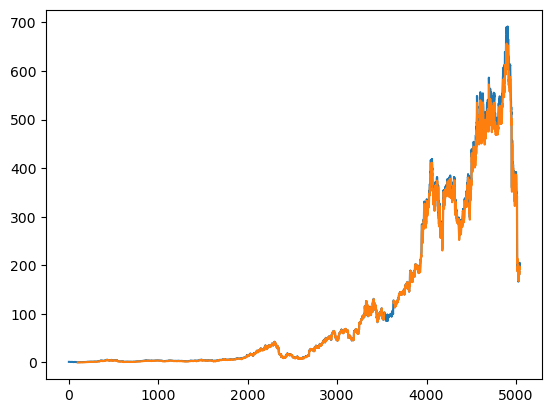

In [27]:
look_back=100
trainPredictPlot = np.empty_like(nflx1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

testPredictPlot = np.empty_like(nflx1)
testPredictPlot[:, :] = np.nan
trainPredictPlot[len(train_predict)+(look_back*2)+1:len(nflx1)-1, :] = test_predict

plt.plot(scaler.inverse_transform(nflx1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [28]:
len(test_data)

1514

In [31]:
x_input = test_data[1414:].reshape(1,-1)
x_input.shape

(1, 100)

In [35]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()
temp_input

[0.781793383700906,
 0.7765569216426708,
 0.7504907968107748,
 0.7598786588751534,
 0.7383400436278778,
 0.7456594006503339,
 0.7346514500229846,
 0.5744500130978235,
 0.559478583451015,
 0.5294923735762403,
 0.5197717973564795,
 0.5588276781418461,
 0.5554427960845668,
 0.6173247128132485,
 0.6607056563019277,
 0.6207095500285906,
 0.586166786012518,
 0.5927773655895658,
 0.581103986651452,
 0.5831724916933745,
 0.596711886843194,
 0.5871359258708967,
 0.5654960879062242,
 0.5731047651074818,
 0.5888572805466873,
 0.575288972472974,
 0.5587842841652653,
 0.5654671735358161,
 0.54534615657478,
 0.5309967164202183,
 0.5636445513006912,
 0.5647583512484706,
 0.5701393851587464,
 0.5581622498310813,
 0.549179410269074,
 0.5318791131673726,
 0.5227082195393836,
 0.5061167013296046,
 0.49382133145273,
 0.51845546518306,
 0.5155334777643913,
 0.4917383468046347,
 0.4782713048437414,
 0.49669988005288074,
 0.5166328429479351,
 0.5366959863262177,
 0.5500039334334749,
 0.5413103692083319,
 0.5

#### Predicting for next 30 days

In [37]:
output1=[]
n_steps=100
i=0
while(i<30):
    if(len(temp_input)>100):
        x_input = np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        output1.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        output1.extend(yhat.tolist())
        i=i+1
print(output1)

[0.28797418]
101
1 day input [0.77655692 0.7504908  0.75987866 0.73834004 0.7456594  0.73465145
 0.57445001 0.55947858 0.52949237 0.5197718  0.55882768 0.5554428
 0.61732471 0.66070566 0.62070955 0.58616679 0.59277737 0.58110399
 0.58317249 0.59671189 0.58713593 0.56549609 0.57310477 0.58885728
 0.57528897 0.55878428 0.56546717 0.54534616 0.53099672 0.56364455
 0.56475835 0.57013939 0.55816225 0.54917941 0.53187911 0.52270822
 0.5061167  0.49382133 0.51845547 0.51553348 0.49173835 0.4782713
 0.49669988 0.51663284 0.53669599 0.55000393 0.54131037 0.55335986
 0.54116571 0.54293046 0.54023996 0.54698072 0.56623382 0.55126239
 0.54131037 0.53969028 0.56577093 0.54935298 0.53228414 0.52331573
 0.5142461  0.50284756 0.49720617 0.50636258 0.49291002 0.48817989
 0.50372992 0.32664768 0.31511897 0.31121338 0.30309844 0.28644905
 0.27218642 0.28806916 0.27481908 0.28798237 0.28857542 0.29456399
 0.2718682  0.26123632 0.24985226 0.25644836 0.2401172  0.25160253
 0.27088456 0.26925    0.27510838 0

8 day output [[0.28314754]]
9 day input [0.52949237 0.5197718  0.55882768 0.5554428  0.61732471 0.66070566
 0.62070955 0.58616679 0.59277737 0.58110399 0.58317249 0.59671189
 0.58713593 0.56549609 0.57310477 0.58885728 0.57528897 0.55878428
 0.56546717 0.54534616 0.53099672 0.56364455 0.56475835 0.57013939
 0.55816225 0.54917941 0.53187911 0.52270822 0.5061167  0.49382133
 0.51845547 0.51553348 0.49173835 0.4782713  0.49669988 0.51663284
 0.53669599 0.55000393 0.54131037 0.55335986 0.54116571 0.54293046
 0.54023996 0.54698072 0.56623382 0.55126239 0.54131037 0.53969028
 0.56577093 0.54935298 0.53228414 0.52331573 0.5142461  0.50284756
 0.49720617 0.50636258 0.49291002 0.48817989 0.50372992 0.32664768
 0.31511897 0.31121338 0.30309844 0.28644905 0.27218642 0.28806916
 0.27481908 0.28798237 0.28857542 0.29456399 0.2718682  0.26123632
 0.24985226 0.25644836 0.2401172  0.25160253 0.27088456 0.26925
 0.27510838 0.25576849 0.26486706 0.26901857 0.27059526 0.260325
 0.2711594  0.27632345 0.28

16 day output [[0.27515715]]
17 day input [0.59277737 0.58110399 0.58317249 0.59671189 0.58713593 0.56549609
 0.57310477 0.58885728 0.57528897 0.55878428 0.56546717 0.54534616
 0.53099672 0.56364455 0.56475835 0.57013939 0.55816225 0.54917941
 0.53187911 0.52270822 0.5061167  0.49382133 0.51845547 0.51553348
 0.49173835 0.4782713  0.49669988 0.51663284 0.53669599 0.55000393
 0.54131037 0.55335986 0.54116571 0.54293046 0.54023996 0.54698072
 0.56623382 0.55126239 0.54131037 0.53969028 0.56577093 0.54935298
 0.53228414 0.52331573 0.5142461  0.50284756 0.49720617 0.50636258
 0.49291002 0.48817989 0.50372992 0.32664768 0.31511897 0.31121338
 0.30309844 0.28644905 0.27218642 0.28806916 0.27481908 0.28798237
 0.28857542 0.29456399 0.2718682  0.26123632 0.24985226 0.25644836
 0.2401172  0.25160253 0.27088456 0.26925    0.27510838 0.25576849
 0.26486706 0.26901857 0.27059526 0.260325   0.2711594  0.27632345
 0.28180575 0.2850604  0.2785077  0.29612623 0.28728803 0.28797418
 0.28675163 0.285950

24 day output [[0.26760334]]
25 day input [0.57528897 0.55878428 0.56546717 0.54534616 0.53099672 0.56364455
 0.56475835 0.57013939 0.55816225 0.54917941 0.53187911 0.52270822
 0.5061167  0.49382133 0.51845547 0.51553348 0.49173835 0.4782713
 0.49669988 0.51663284 0.53669599 0.55000393 0.54131037 0.55335986
 0.54116571 0.54293046 0.54023996 0.54698072 0.56623382 0.55126239
 0.54131037 0.53969028 0.56577093 0.54935298 0.53228414 0.52331573
 0.5142461  0.50284756 0.49720617 0.50636258 0.49291002 0.48817989
 0.50372992 0.32664768 0.31511897 0.31121338 0.30309844 0.28644905
 0.27218642 0.28806916 0.27481908 0.28798237 0.28857542 0.29456399
 0.2718682  0.26123632 0.24985226 0.25644836 0.2401172  0.25160253
 0.27088456 0.26925    0.27510838 0.25576849 0.26486706 0.26901857
 0.27059526 0.260325   0.2711594  0.27632345 0.28180575 0.2850604
 0.2785077  0.29612623 0.28728803 0.28797418 0.28675163 0.28595042
 0.28541645 0.28505975 0.28474572 0.28435981 0.28383374 0.28314754
 0.28231698 0.2813772 

In [39]:
day_new = np.arange(1, 101)
day_pred = np.arange(101, 131)

In [40]:
len(nflx1)

5044

#### Graph of actual values in last 100 days

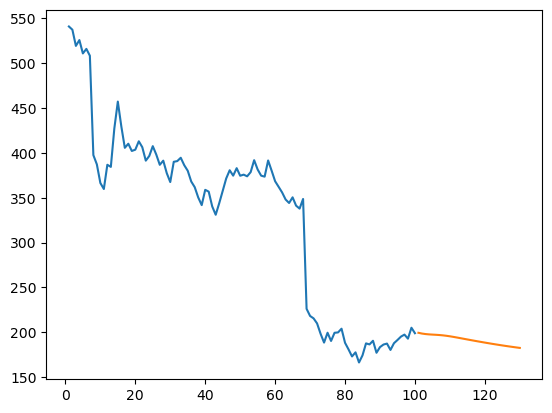

In [43]:
plt.plot(day_new, scaler.inverse_transform(nflx1[4944:]))
plt.plot(day_pred, scaler.inverse_transform(output1));

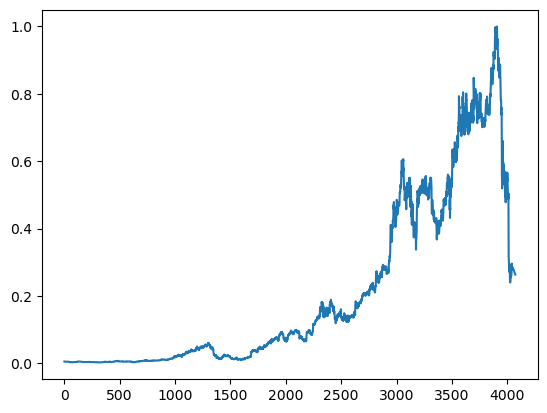

In [45]:
nflx2 = nflx1.tolist()
nflx2.extend(output1)
plt.plot(nflx2[1000:]);

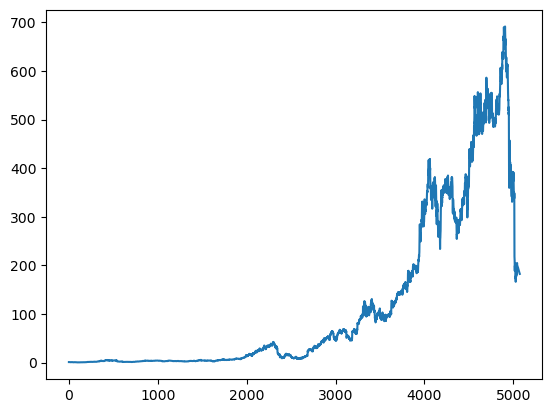

In [47]:
nflx2 = scaler.inverse_transform(nflx2).tolist()
plt.plot(nflx2);